In [1]:
#Importing the necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import keras.backend as K
from keras.models import Sequential, load_model
from keras.layers import Dense, SimpleRNN, Dropout, Lambda, LSTM, GRU, Bidirectional, Layer, Attention, Activation, Flatten, GlobalMaxPooling1D
from keras_self_attention import SeqSelfAttention
from keras.utils.generic_utils import get_custom_objects
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from math import sin
from scipy.linalg import expm

#import warnings
#warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('Customers_in_a_Shop.csv', header=None)
df.head()

,0,1
0,1949-01,114.0
1,1949-02,120.0
2,1949-03,134.0
3,1949-04,67.0
4,1949-05,123.0


In [3]:
df.columns={"Date","Customers"}
print(df.isnull().sum())

Date         0
Customers    4
dtype: int64


In [4]:
df['Date'] = pd.to_datetime(df['Date'],format="%Y-%m")
df = df.set_index('Date')
df

,Customers
Date,
1949-01-01,114.0
1949-02-01,120.0
1949-03-01,134.0
1949-04-01,67.0
1949-05-01,123.0
...,...
1960-08-01,606.0
1960-09-01,508.0
1960-10-01,720.0


In [5]:
missing = df[df.isna().any(axis=1)]
print(missing)

            Customers
Date                 
1951-06-01        NaN
1951-07-01        NaN
1954-06-01        NaN
1960-03-01        NaN


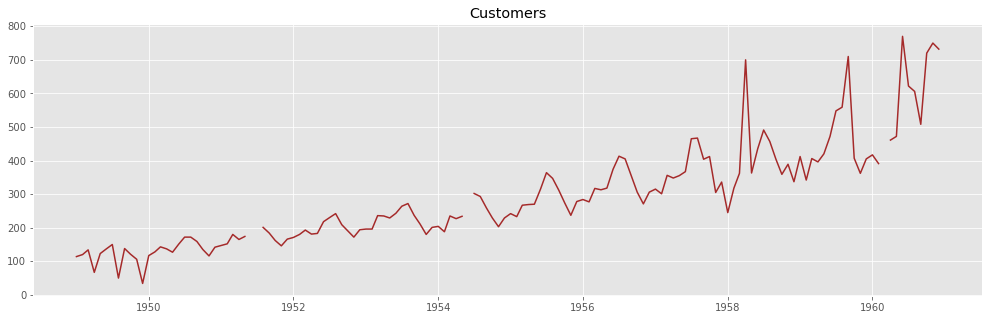

In [6]:
#from matplotlib import style
#print(plt.style.available)

plt.style.use('ggplot')
plt.rcParams['figure.figsize']=(17,5)

plt.plot(df, color='brown')
plt.title("Customers")
plt.show()

## Imputing missing values

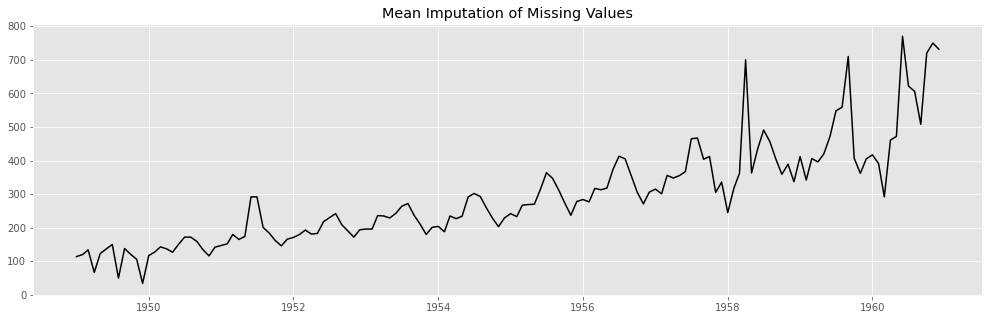

In [7]:
## Comparing several types of interpolations - mean 
plt.rcParams['figure.figsize']=(17,5)
df['Customers_mean'] = df['Customers'].fillna(df['Customers'].mean())
plt.plot(df['Customers_mean'],color='black')
plt.title("Mean Imputation of Missing Values")
plt.show()

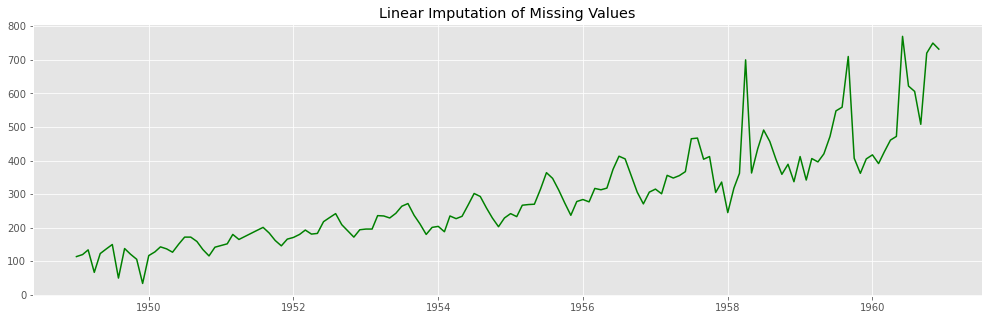

In [8]:
## Comparing several types of interpolations - linear
plt.rcParams['figure.figsize']=(17,5)
df['Customers_linear'] = df['Customers'].interpolate(method='linear')
plt.plot(df['Customers_linear'],color='green')
plt.title("Linear Imputation of Missing Values")
plt.show()

In [9]:
df1 = df['1949-06':'1960-06':12]
df1

,Customers,Customers_mean,Customers_linear
Date,,,
1949-06-01,137.0,137.000000,137.0
1950-06-01,151.0,151.000000,151.0
1951-06-01,NaN,291.878571,183.0
1952-06-01,218.0,218.000000,218.0
1953-06-01,243.0,243.000000,243.0
1954-06-01,NaN,291.878571,268.0
1955-06-01,315.0,315.000000,315.0
1956-06-01,374.0,374.000000,374.0
1957-06-01,367.0,367.000000,367.0


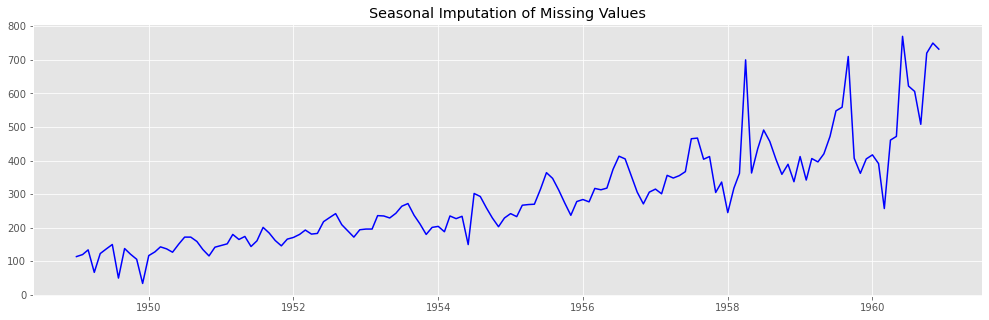

In [10]:
## Comparing several types of interpolations - seasonal interpolation
df.loc['1960-03'].fillna((df['1949-03':'1959-03':12].sum())/df['1949-03':'1959-03':12].shape[0], inplace=True)
df.loc['1954-06'].fillna((df['1949-06':'1953-06':12].sum())/(df['1949-06':'1953-06':12].shape[0]), inplace=True)
df.loc['1951-07'].fillna((df['1949-07':'1950-07':12].sum())/(df.loc['1949-07':'1950-07':12].shape[0]), inplace=True)
df.loc['1951-06'].fillna((df['1949-06':'1950-06':12].sum())/(df['1949-06':'1950-06':12].shape[0]), inplace=True)

plt.rcParams['figure.figsize']=(17,5)
plt.plot(df['Customers'],color='blue')
plt.title("Seasonal Imputation of Missing Values")
plt.show()

In [11]:
df['Customers'].sort_values(ascending=False).head(7)

Date
1960-06-01    770.0
1960-11-01    750.0
1960-12-01    732.0
1960-10-01    720.0
1959-09-01    710.0
1958-04-01    700.0
1960-07-01    622.0
Name: Customers, dtype: float64

## Normality plots 

/home/ardavan/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Customers', ylabel='Density'>

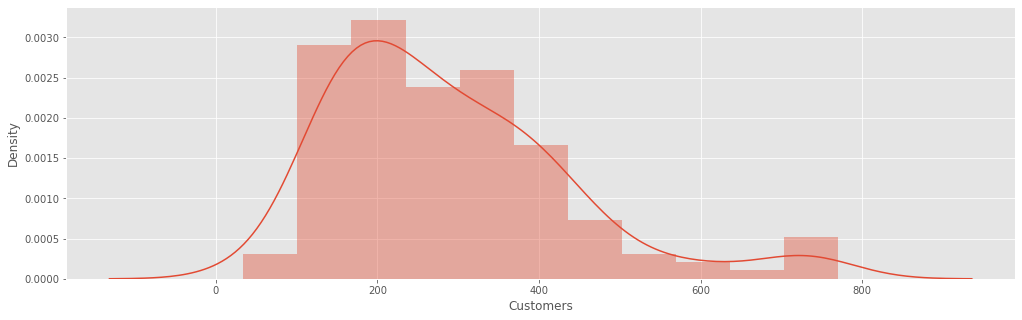

In [12]:
sns.distplot(df['Customers'])

((array([-2.58977345, -2.26833208, -2.08397164, -1.95134078, -1.84615093,
         -1.75813779, -1.68195358, -1.61444188, -1.55357684, -1.49797725,
         -1.44665728, -1.39888755, -1.35411252, -1.31189888, -1.27190175,
         -1.23384196, -1.19749012, -1.16265539, -1.12917712, -1.09691879,
         -1.06576327, -1.03560932, -1.00636876, -0.97796428, -0.95032771,
         -0.92339857, -0.89712296, -0.87145259, -0.84634402, -0.82175802,
         -0.797659  , -0.77401457, -0.75079515, -0.72797364, -0.70552513,
         -0.68342667, -0.66165704, -0.64019656, -0.61902697, -0.59813124,
         -0.57749349, -0.55709882, -0.53693331, -0.51698381, -0.49723799,
         -0.47768418, -0.45831134, -0.43910901, -0.42006725, -0.40117661,
         -0.38242807, -0.36381301, -0.34532319, -0.32695068, -0.30868788,
         -0.29052747, -0.27246238, -0.25448578, -0.23659106, -0.21877178,
         -0.2010217 , -0.18333474, -0.16570495, -0.14812651, -0.13059373,
         -0.11310101, -0.09564283, -0.

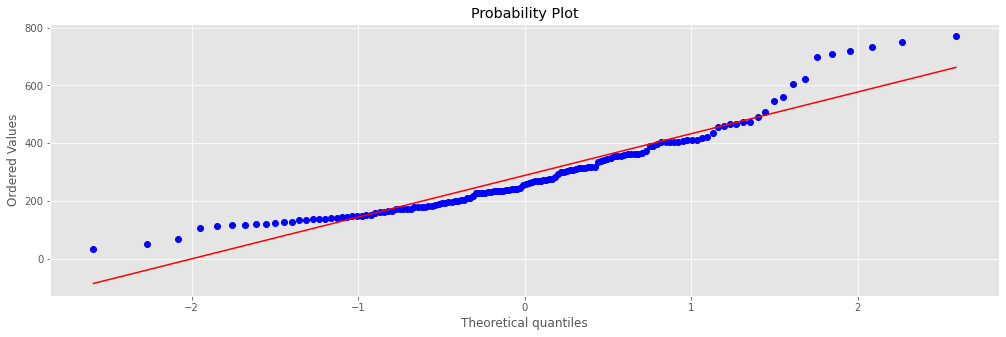

In [13]:
import scipy.stats
import pylab 
scipy.stats.probplot(df['Customers'],plot=pylab)
# pylab.show()

# Y-Axis: Data Value
# X-Axis: 

# Naive Decomposition
### Additive Seasonal Decomposition

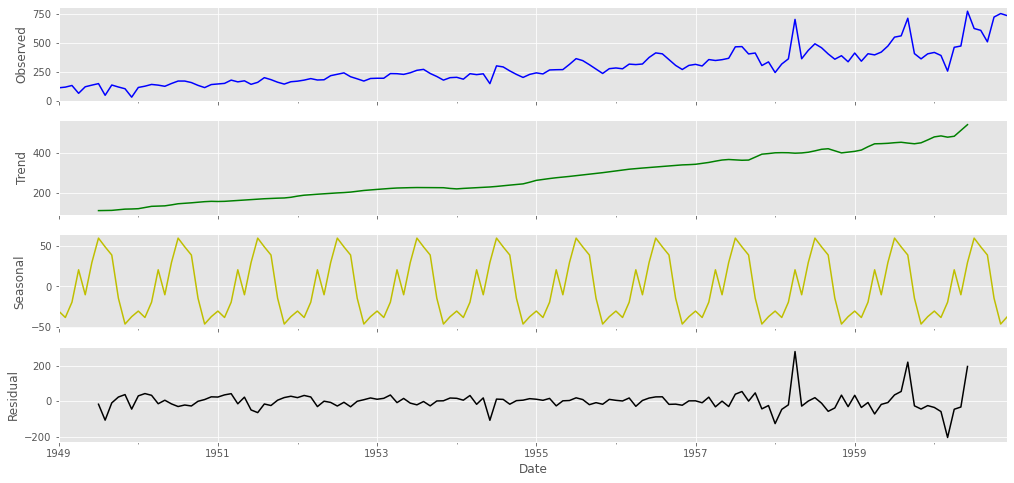

In [14]:
import statsmodels.api as sm

plt.rcParams['figure.figsize'] = (17,8)

decomposition = sm.tsa.seasonal_decompose(df['Customers'], model='additive')
#decomposition.plot()

fig, axes = plt.subplots(4, 1, sharex=True)

decomposition.observed.plot(ax=axes[0], legend=False, color='b')
axes[0].set_ylabel('Observed')
decomposition.trend.plot(ax=axes[1], legend=False, color='g')
axes[1].set_ylabel('Trend')
decomposition.seasonal.plot(ax=axes[2], legend=False, color='y')
axes[2].set_ylabel('Seasonal')
decomposition.resid.plot(ax=axes[3], legend=False, color='k')
axes[3].set_ylabel('Residual')                           
plt.show()

### Multiplicative Seasonal Decomposition

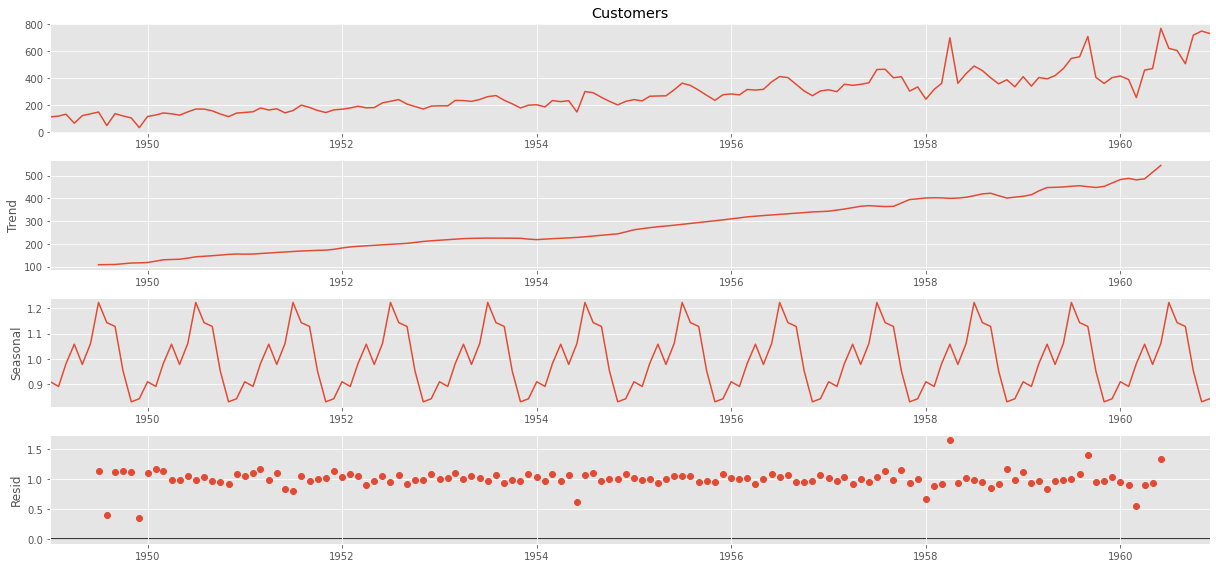

In [15]:
import statsmodels.api as sm
plt.rcParams['figure.figsize'] = (17,8)

decomposition = sm.tsa.seasonal_decompose(df['Customers'], model='multiplicative')
fig = decomposition.plot()
plt.show()

## Splitting Train and Test data

In [16]:
length = int(np.round(len(df["Customers_linear"])*0.8))
print(length)

115


In [17]:
df.drop(columns=["Customers_mean","Customers_linear"], inplace=True)
df.index.freq = 'MS'

In [18]:
## iF removing of the index is needed.
#df.reset_index(drop=True, inplace=True)
#df

In [19]:
train = df.iloc[:length,:]
train

,Customers
Date,
1949-01-01,114.0
1949-02-01,120.0
1949-03-01,134.0
1949-04-01,67.0
1949-05-01,123.0
...,...
1958-03-01,362.0
1958-04-01,700.0
1958-05-01,363.0


In [20]:
test = df.iloc[length:,: ]
test

,Customers
Date,
1958-08-01,457.000000
1958-09-01,404.000000
1958-10-01,359.000000
1958-11-01,389.000000
1958-12-01,337.000000
1959-01-01,412.000000
1959-02-01,342.000000
1959-03-01,406.000000
1959-04-01,396.000000


In [21]:
print(test.shape)
print(train.shape)

(29, 1)
(115, 1)


In [22]:
SC = StandardScaler()
train = SC.fit_transform(train)
test = SC.transform(test)
train

array([[-1.21245702],
       [-1.15425422],
       [-1.0184477 ],
       [-1.66837891],
       [-1.12515282],
       [-0.9893463 ],
       [-0.86324024],
       [-1.83328683],
       [-0.97964583],
       [-1.14455375],
       [-1.29006074],
       [-1.98849429],
       [-1.18335562],
       [-1.07665049],
       [-0.9311435 ],
       [-0.9893463 ],
       [-1.08635096],
       [-0.85353978],
       [-0.64982999],
       [-0.64982999],
       [-0.77593605],
       [-1.00874723],
       [-1.19305608],
       [-0.94084397],
       [-0.89234164],
       [-0.84383931],
       [-0.57222627],
       [-0.71773325],
       [-0.63042906],
       [-0.92144304],
       [-0.75653512],
       [-0.36851648],
       [-0.5334244 ],
       [-0.74683465],
       [-0.90204211],
       [-0.70803279],
       [-0.65953046],
       [-0.57222627],
       [-0.44612021],
       [-0.5625258 ],
       [-0.54312487],
       [-0.20360856],
       [-0.08720297],
       [ 0.02920262],
       [-0.29091276],
       [-0

### Change Data to RNN Architecture

In [23]:
stepsize = 18 #Should be optimized!

def RNN_Structure(df, stepsize):
    X =[]
    Y =[]
    
    for n in range(len(df) - stepsize):
        z = n + stepsize
        X.append(df[n:z,]) #sample =10
        Y.append(df[z,])   #sample = 11 is your label
        
    return np.array(X) , np.array(Y)

        
X_train ,Y_train =  RNN_Structure(train, stepsize)
X_test  , Y_test =  RNN_Structure(test, stepsize)

In [24]:
print(X_train.shape) # X_train value with step = 10
print(X_test.shape)  # X_Test value with step = 10
print(Y_train.shape) # X_train value with step = 10
print(Y_test.shape)  # X_Test value with step = 10

(97, 18, 1)
(11, 18, 1)
(97, 1)
(11, 1)


* First Argument: Sample size
* Second Argument: Time Step
* Third Argument: Number of Feature

**(Sample size, Step Lenght/Sequence Lenght, Number of Input Feature/ Input Value to RNN)**

In [25]:
## Not necessary for this series, since already done in the previous definition function. But in case:

# X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
# X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
# print(X_train.shape)
# print(X_test.shape)

In [26]:
X_train = np.asarray(X_train).astype(np.float32)
X_test = np.asarray(X_test).astype(np.float32)
Y_train = np.asarray(Y_train).astype(np.float32)
Y_test = np.asarray(Y_test).astype(np.float32)

### Simple RNN

In [461]:
def custom_loss_function(y_true, y_pred):
    loss = K.pow(K.abs(y_true - y_pred), 3)
    return loss

In [462]:
def bern_sigm(x):
    bias1 = K.random_bernoulli(shape=[1])
    return K.sigmoid(x) + K.bias_add(x, bias1)
get_custom_objects().update({'bern_sigm': Activation(bern_sigm)})

In [463]:
RNN = Sequential()
RNN.add(SimpleRNN(units=512, return_sequences=False, activation = "relu"))
RNN.add(Dense(1, activation="bern_sigm"))
RNN.compile(loss = custom_loss_function, optimizer = "nadam", metrics="logcosh")

In [464]:
memory = RNN.fit(X_train, Y_train, epochs = 500, batch_size = 20, use_multiprocessing=True) 

Epoch 1/500
5/5 [==============================] - 1s 11ms/step - loss: 1.1026 - logcosh: 0.2193
Epoch 2/500
5/5 [==============================] - 0s 10ms/step - loss: 0.6314 - logcosh: 0.1443
Epoch 3/500
5/5 [==============================] - 0s 11ms/step - loss: 0.4765 - logcosh: 0.1040
Epoch 4/500
5/5 [==============================] - 0s 11ms/step - loss: 0.4621 - logcosh: 0.1250
Epoch 5/500
5/5 [==============================] - 0s 11ms/step - loss: 0.3730 - logcosh: 0.1006
Epoch 6/500
5/5 [==============================] - 0s 11ms/step - loss: 0.9167 - logcosh: 0.1698
Epoch 7/500
5/5 [==============================] - 0s 13ms/step - loss: 0.5447 - logcosh: 0.0989
Epoch 8/500
5/5 [==============================] - 0s 13ms/step - loss: 0.4435 - logcosh: 0.0909
Epoch 9/500
5/5 [==============================] - 0s 9ms/step - loss: 0.3753 - logcosh: 0.0855
Epoch 10/500
5/5 [==============================] - 0s 11ms/step - loss: 0.3215 - logcosh: 0.0907
Epoch 11/500
5/5 [============

5/5 [==============================] - 0s 10ms/step - loss: 1.4665e-05 - logcosh: 2.1726e-04
Epoch 83/500
5/5 [==============================] - 0s 11ms/step - loss: 1.4423e-05 - logcosh: 2.1806e-04
Epoch 84/500
5/5 [==============================] - 0s 9ms/step - loss: 1.2308e-05 - logcosh: 1.9451e-04
Epoch 85/500
5/5 [==============================] - 0s 11ms/step - loss: 1.2108e-05 - logcosh: 1.9696e-04
Epoch 86/500
5/5 [==============================] - 0s 9ms/step - loss: 1.1278e-05 - logcosh: 1.8531e-04
Epoch 87/500
5/5 [==============================] - 0s 11ms/step - loss: 1.0564e-05 - logcosh: 1.7881e-04
Epoch 88/500
5/5 [==============================] - 0s 9ms/step - loss: 1.0105e-05 - logcosh: 1.6975e-04
Epoch 89/500
5/5 [==============================] - 0s 12ms/step - loss: 9.9703e-06 - logcosh: 1.6949e-04
Epoch 90/500
5/5 [==============================] - 0s 9ms/step - loss: 9.2882e-06 - logcosh: 1.6380e-04
Epoch 91/500
5/5 [==============================] - 0s 11ms/ste

Epoch 159/500
5/5 [==============================] - 0s 11ms/step - loss: 4.6930e-07 - logcosh: 2.3421e-05
Epoch 160/500
5/5 [==============================] - 0s 10ms/step - loss: 4.7016e-07 - logcosh: 2.3384e-05
Epoch 161/500
5/5 [==============================] - 0s 11ms/step - loss: 4.4302e-07 - logcosh: 2.2517e-05
Epoch 162/500
5/5 [==============================] - 0s 12ms/step - loss: 4.3278e-07 - logcosh: 2.2015e-05
Epoch 163/500
5/5 [==============================] - 0s 11ms/step - loss: 4.3846e-07 - logcosh: 2.2340e-05
Epoch 164/500
5/5 [==============================] - 0s 11ms/step - loss: 4.2502e-07 - logcosh: 2.1772e-05
Epoch 165/500
5/5 [==============================] - 0s 11ms/step - loss: 3.9619e-07 - logcosh: 2.0949e-05
Epoch 166/500
5/5 [==============================] - 0s 11ms/step - loss: 3.8996e-07 - logcosh: 2.0623e-05
Epoch 167/500
5/5 [==============================] - 0s 10ms/step - loss: 3.7559e-07 - logcosh: 2.0203e-05
Epoch 168/500
5/5 [==================

5/5 [==============================] - 0s 11ms/step - loss: 7.0615e-08 - logcosh: 6.7132e-06
Epoch 236/500
5/5 [==============================] - 0s 12ms/step - loss: 6.8344e-08 - logcosh: 6.5971e-06
Epoch 237/500
5/5 [==============================] - 0s 11ms/step - loss: 6.5243e-08 - logcosh: 6.4146e-06
Epoch 238/500
5/5 [==============================] - 0s 11ms/step - loss: 6.3774e-08 - logcosh: 6.3709e-06
Epoch 239/500
5/5 [==============================] - 0s 11ms/step - loss: 6.3277e-08 - logcosh: 6.2646e-06
Epoch 240/500
5/5 [==============================] - 0s 11ms/step - loss: 6.3084e-08 - logcosh: 6.3076e-06
Epoch 241/500
5/5 [==============================] - 0s 11ms/step - loss: 6.2483e-08 - logcosh: 6.2069e-06
Epoch 242/500
5/5 [==============================] - 0s 11ms/step - loss: 5.9415e-08 - logcosh: 6.0711e-06
Epoch 243/500
5/5 [==============================] - 0s 12ms/step - loss: 5.8921e-08 - logcosh: 5.9820e-06
Epoch 244/500
5/5 [==============================] 

5/5 [==============================] - 0s 11ms/step - loss: 1.6000e-08 - logcosh: 2.5495e-06
Epoch 312/500
5/5 [==============================] - 0s 11ms/step - loss: 1.5682e-08 - logcosh: 2.5151e-06
Epoch 313/500
5/5 [==============================] - 0s 11ms/step - loss: 1.5101e-08 - logcosh: 2.4579e-06
Epoch 314/500
5/5 [==============================] - 0s 11ms/step - loss: 1.5169e-08 - logcosh: 2.4456e-06
Epoch 315/500
5/5 [==============================] - 0s 11ms/step - loss: 1.4747e-08 - logcosh: 2.4174e-06
Epoch 316/500
5/5 [==============================] - 0s 10ms/step - loss: 1.4710e-08 - logcosh: 2.4106e-06
Epoch 317/500
5/5 [==============================] - 0s 11ms/step - loss: 1.4190e-08 - logcosh: 2.3559e-06
Epoch 318/500
5/5 [==============================] - 0s 11ms/step - loss: 1.4114e-08 - logcosh: 2.3504e-06
Epoch 319/500
5/5 [==============================] - 0s 11ms/step - loss: 1.3710e-08 - logcosh: 2.2994e-06
Epoch 320/500
5/5 [==============================] 

5/5 [==============================] - 0s 11ms/step - loss: 4.9908e-09 - logcosh: 1.1694e-06
Epoch 388/500
5/5 [==============================] - 0s 10ms/step - loss: 4.7853e-09 - logcosh: 1.1374e-06
Epoch 389/500
5/5 [==============================] - 0s 12ms/step - loss: 4.7849e-09 - logcosh: 1.1429e-06
Epoch 390/500
5/5 [==============================] - 0s 10ms/step - loss: 4.6833e-09 - logcosh: 1.1208e-06
Epoch 391/500
5/5 [==============================] - 0s 11ms/step - loss: 4.5993e-09 - logcosh: 1.1079e-06
Epoch 392/500
5/5 [==============================] - 0s 10ms/step - loss: 4.6337e-09 - logcosh: 1.1024e-06
Epoch 393/500
5/5 [==============================] - 0s 11ms/step - loss: 4.5180e-09 - logcosh: 1.1011e-06
Epoch 394/500
5/5 [==============================] - 0s 10ms/step - loss: 4.4292e-09 - logcosh: 1.0846e-06
Epoch 395/500
5/5 [==============================] - 0s 11ms/step - loss: 4.4156e-09 - logcosh: 1.0747e-06
Epoch 396/500
5/5 [==============================] 

5/5 [==============================] - 0s 10ms/step - loss: 1.7915e-09 - logcosh: 5.9113e-07
Epoch 464/500
5/5 [==============================] - 0s 10ms/step - loss: 1.7609e-09 - logcosh: 5.8314e-07
Epoch 465/500
5/5 [==============================] - 0s 9ms/step - loss: 1.7400e-09 - logcosh: 5.8068e-07
Epoch 466/500
5/5 [==============================] - 0s 10ms/step - loss: 1.7263e-09 - logcosh: 5.8130e-07
Epoch 467/500
5/5 [==============================] - 0s 10ms/step - loss: 1.7149e-09 - logcosh: 5.8314e-07
Epoch 468/500
5/5 [==============================] - 0s 10ms/step - loss: 1.6542e-09 - logcosh: 5.6717e-07
Epoch 469/500
5/5 [==============================] - 0s 10ms/step - loss: 1.6529e-09 - logcosh: 5.6348e-07
Epoch 470/500
5/5 [==============================] - 0s 10ms/step - loss: 1.6159e-09 - logcosh: 5.5795e-07
Epoch 471/500
5/5 [==============================] - 0s 10ms/step - loss: 1.6125e-09 - logcosh: 5.4750e-07
Epoch 472/500
5/5 [==============================] -

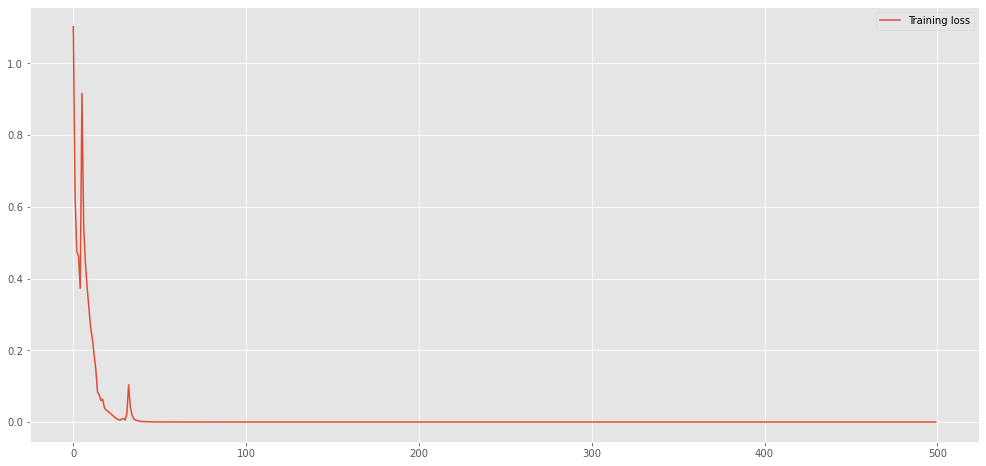

In [465]:
Loss_func = memory.history["loss"]
plt.plot(Loss_func, label= "Training loss")
plt.legend()

In [466]:
RNN.summary()

Model: "sequential_66"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_66 (SimpleRNN)    (None, 512)               263168    
_________________________________________________________________
dense_66 (Dense)             (None, 1)                 513       
Total params: 263,681
Trainable params: 263,681
Non-trainable params: 0
_________________________________________________________________


In [467]:
score = RNN.evaluate(X_train, Y_train, verbose = 0)
score #Customized loss and Logcosh

[1.0740964784261564e-09, 4.258352532815479e-07]

In [468]:
#X_train = np.reshape(X_train, (-1,1))
#X_test = np.reshape(X_test, (-1,1))
print(X_train.shape)
print(X_test.shape)

(97, 18, 1)
(11, 18, 1)


In [469]:
pred_train = SC.inverse_transform(RNN.predict(X_train))
pred_test = SC.inverse_transform(RNN.predict(X_test))

pred = pd.DataFrame(np.concatenate((pred_train,pred_test), axis = 0))

In [470]:
pred

,0
0,171.955811
1,171.970352
2,159.091904
3,134.884247
4,115.905037
...,...
103,864.597839
104,585.757935
105,324.159760
106,488.419708


In [471]:
df.reset_index(inplace=True, drop=True)
df

,Customers
0,114.0
1,120.0
2,134.0
3,67.0
4,123.0
...,...
139,606.0
140,508.0
141,720.0
142,750.0


<function matplotlib.pyplot.show(close=None, block=None)>

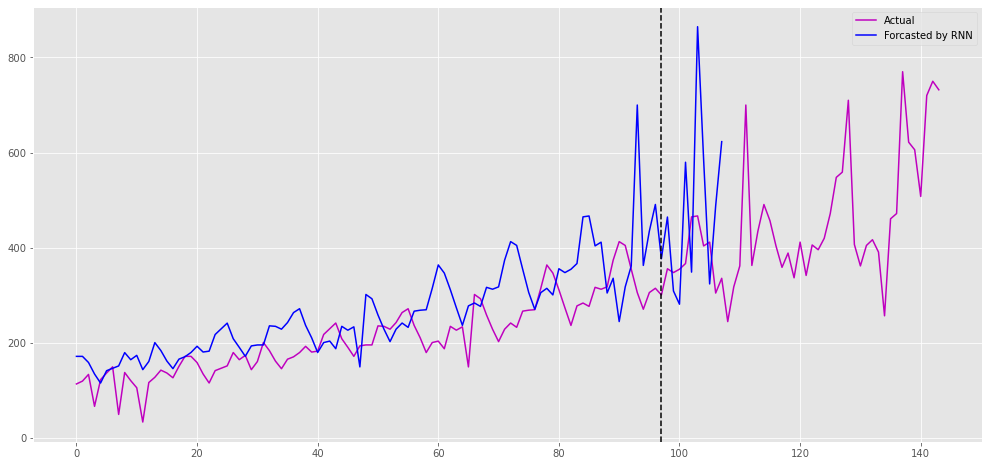

In [472]:
plt.plot(df, color="m")
plt.plot(pred, color="blue")
plt.legend(["Actual","Forcasted by RNN"])
plt.axvline(len(X_train), c= "k", linestyle='dashed')
plt.show

### Long-Short Term Memory (LSTM)

In [473]:
lstm = Sequential()
lstm.add(LSTM(units=512, return_sequences=False, activation ="selu"))
lstm.add(Dense(1, activation="bern_sigm"))
lstm.compile(loss =custom_loss_function, optimizer='nadam', metrics="logcosh")
memory_lstm = lstm.fit(X_train, Y_train , epochs = 250, batch_size = 20, verbose = 1)

Epoch 1/250
5/5 [==============================] - 1s 51ms/step - loss: 1.1995 - logcosh: 0.3309
Epoch 2/250
5/5 [==============================] - 0s 42ms/step - loss: 1.2199 - logcosh: 0.1985
Epoch 3/250
5/5 [==============================] - 0s 41ms/step - loss: 0.5281 - logcosh: 0.1113
Epoch 4/250
5/5 [==============================] - 0s 41ms/step - loss: 0.6853 - logcosh: 0.1413
Epoch 5/250
5/5 [==============================] - 0s 41ms/step - loss: 0.3882 - logcosh: 0.1023
Epoch 6/250
5/5 [==============================] - 0s 42ms/step - loss: 0.5040 - logcosh: 0.1304
Epoch 7/250
5/5 [==============================] - 0s 42ms/step - loss: 0.4313 - logcosh: 0.0968
Epoch 8/250
5/5 [==============================] - 0s 42ms/step - loss: 0.3592 - logcosh: 0.1087
Epoch 9/250
5/5 [==============================] - 0s 41ms/step - loss: 0.2633 - logcosh: 0.0843
Epoch 10/250
5/5 [==============================] - 0s 42ms/step - loss: 0.2543 - logcosh: 0.0983
Epoch 11/250
5/5 [===========

5/5 [==============================] - 0s 41ms/step - loss: 0.1716 - logcosh: 0.0720
Epoch 85/250
5/5 [==============================] - 0s 40ms/step - loss: 0.1552 - logcosh: 0.0747
Epoch 86/250
5/5 [==============================] - 0s 43ms/step - loss: 0.1305 - logcosh: 0.0624
Epoch 87/250
5/5 [==============================] - 0s 42ms/step - loss: 0.1599 - logcosh: 0.0825
Epoch 88/250
5/5 [==============================] - 0s 41ms/step - loss: 0.1377 - logcosh: 0.0659
Epoch 89/250
5/5 [==============================] - 0s 42ms/step - loss: 0.1998 - logcosh: 0.0909
Epoch 90/250
5/5 [==============================] - 0s 41ms/step - loss: 0.1411 - logcosh: 0.0737
Epoch 91/250
5/5 [==============================] - 0s 43ms/step - loss: 0.1067 - logcosh: 0.0569
Epoch 92/250
5/5 [==============================] - 0s 41ms/step - loss: 0.1076 - logcosh: 0.0639
Epoch 93/250
5/5 [==============================] - 0s 40ms/step - loss: 0.1314 - logcosh: 0.0612
Epoch 94/250
5/5 [===============

5/5 [==============================] - 0s 42ms/step - loss: 0.0183 - logcosh: 0.0224
Epoch 168/250
5/5 [==============================] - 0s 42ms/step - loss: 0.0162 - logcosh: 0.0201
Epoch 169/250
5/5 [==============================] - 0s 43ms/step - loss: 0.0177 - logcosh: 0.0212
Epoch 170/250
5/5 [==============================] - 0s 42ms/step - loss: 0.0168 - logcosh: 0.0209
Epoch 171/250
5/5 [==============================] - 0s 42ms/step - loss: 0.0167 - logcosh: 0.0202
Epoch 172/250
5/5 [==============================] - 0s 42ms/step - loss: 0.0184 - logcosh: 0.0223
Epoch 173/250
5/5 [==============================] - 0s 41ms/step - loss: 0.0179 - logcosh: 0.0220
Epoch 174/250
5/5 [==============================] - 0s 40ms/step - loss: 0.0165 - logcosh: 0.0208
Epoch 175/250
5/5 [==============================] - 0s 41ms/step - loss: 0.0169 - logcosh: 0.0203
Epoch 176/250
5/5 [==============================] - 0s 42ms/step - loss: 0.0210 - logcosh: 0.0223
Epoch 177/250
5/5 [=====

5/5 [==============================] - 0s 42ms/step - loss: 0.0164 - logcosh: 0.0198
Epoch 250/250
5/5 [==============================] - 0s 41ms/step - loss: 0.0178 - logcosh: 0.0219


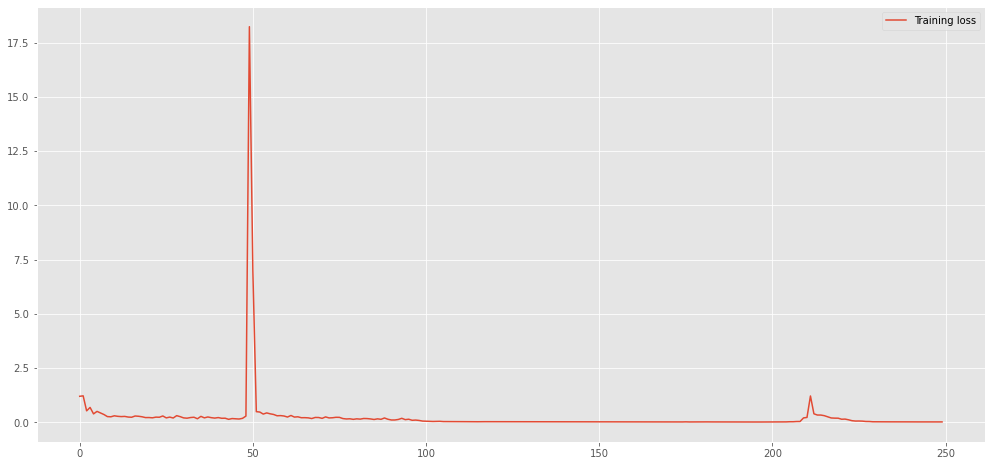

In [474]:
Loss_func = memory_lstm.history["loss"]
plt.plot(Loss_func, label= "Training loss")
plt.legend()

In [475]:
pred_train = SC.inverse_transform(lstm.predict(X_train))
pred_test = SC.inverse_transform(lstm.predict(X_test))

pred = pd.DataFrame(np.concatenate((pred_train,pred_test), axis = 0))

In [476]:
lstm.summary()

Model: "sequential_67"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 512)               1052672   
_________________________________________________________________
dense_67 (Dense)             (None, 1)                 513       
Total params: 1,053,185
Trainable params: 1,053,185
Non-trainable params: 0
_________________________________________________________________


In [477]:
score = lstm.evaluate(X_train, Y_train, verbose = 0)
score #Customized loss and Logcosh        #Question: Why is the RNN's performance better than LSTM?!

[0.013643722049891949, 0.018164686858654022]

<function matplotlib.pyplot.show(close=None, block=None)>

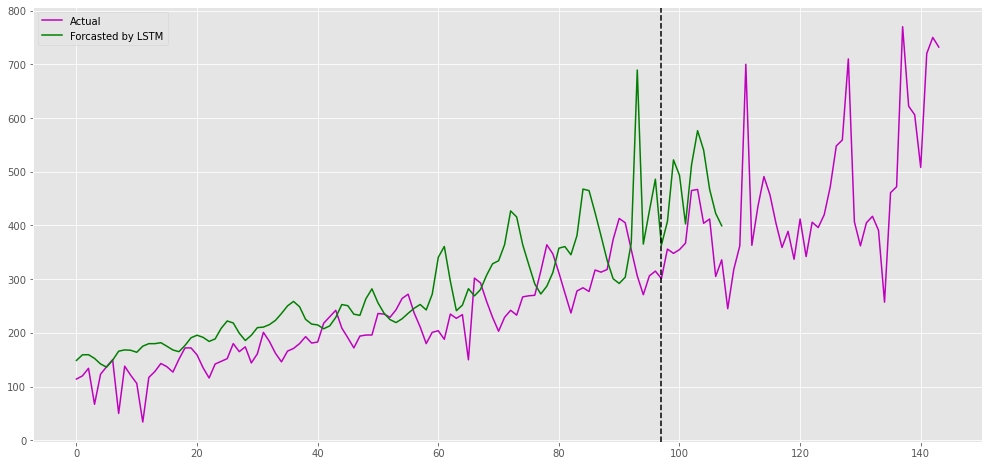

In [478]:
plt.plot(df, color="m")
plt.plot(pred, color="green")
plt.legend(["Actual","Forcasted by LSTM"])
plt.axvline(len(X_train), c= "k", linestyle='dashed')
plt.show #The manual loss function that worked well seems to fail for LSTM!!

### Bi-LSTM

In [479]:
bilstm = Sequential()
bilstm.add(Bidirectional(LSTM(units=512, return_sequences=False, activation ="relu")))
bilstm.add(Dense(1, activation="bern_sigm"))
bilstm.compile(loss = custom_loss_function, optimizer='nadam', metrics="logcosh")
memory_bilstm = bilstm.fit(X_train, Y_train , epochs = 250, batch_size = 20, verbose = 1)

Epoch 1/250
5/5 [==============================] - 2s 75ms/step - loss: 0.9128 - logcosh: 0.2174
Epoch 2/250
5/5 [==============================] - 0s 75ms/step - loss: 0.5988 - logcosh: 0.1256
Epoch 3/250
5/5 [==============================] - 0s 76ms/step - loss: 0.4607 - logcosh: 0.1198
Epoch 4/250
5/5 [==============================] - 0s 75ms/step - loss: 0.4471 - logcosh: 0.1029
Epoch 5/250
5/5 [==============================] - 0s 78ms/step - loss: 0.5323 - logcosh: 0.1464
Epoch 6/250
5/5 [==============================] - 0s 75ms/step - loss: 0.5158 - logcosh: 0.1024
Epoch 7/250
5/5 [==============================] - 0s 76ms/step - loss: 0.4736 - logcosh: 0.0992
Epoch 8/250
5/5 [==============================] - 0s 75ms/step - loss: 0.4430 - logcosh: 0.1023
Epoch 9/250
5/5 [==============================] - 0s 74ms/step - loss: 0.4133 - logcosh: 0.1051
Epoch 10/250
5/5 [==============================] - 0s 75ms/step - loss: 0.4580 - logcosh: 0.1137
Epoch 11/250
5/5 [===========

5/5 [==============================] - 0s 75ms/step - loss: 0.1266 - logcosh: 0.0711
Epoch 85/250
5/5 [==============================] - 0s 74ms/step - loss: 0.1171 - logcosh: 0.0636
Epoch 86/250
5/5 [==============================] - 0s 75ms/step - loss: 0.1111 - logcosh: 0.0618
Epoch 87/250
5/5 [==============================] - 0s 75ms/step - loss: 0.0922 - logcosh: 0.0599
Epoch 88/250
5/5 [==============================] - 0s 74ms/step - loss: 0.0866 - logcosh: 0.0563
Epoch 89/250
5/5 [==============================] - 0s 74ms/step - loss: 0.0811 - logcosh: 0.0622
Epoch 90/250
5/5 [==============================] - 0s 75ms/step - loss: 16.1796 - logcosh: 0.4463
Epoch 91/250
5/5 [==============================] - 0s 75ms/step - loss: 0.3650 - logcosh: 0.1333
Epoch 92/250
5/5 [==============================] - 0s 76ms/step - loss: 0.2271 - logcosh: 0.0855
Epoch 93/250
5/5 [==============================] - 0s 75ms/step - loss: 0.2277 - logcosh: 0.0981
Epoch 94/250
5/5 [==============

5/5 [==============================] - 0s 74ms/step - loss: 0.0465 - logcosh: 0.0445
Epoch 168/250
5/5 [==============================] - 0s 74ms/step - loss: 0.4543 - logcosh: 0.1008
Epoch 169/250
5/5 [==============================] - 0s 75ms/step - loss: 0.1387 - logcosh: 0.0720
Epoch 170/250
5/5 [==============================] - 0s 76ms/step - loss: 0.2401 - logcosh: 0.0725
Epoch 171/250
5/5 [==============================] - 0s 75ms/step - loss: 0.1167 - logcosh: 0.0625
Epoch 172/250
5/5 [==============================] - 0s 74ms/step - loss: 0.1037 - logcosh: 0.0569
Epoch 173/250
5/5 [==============================] - 0s 74ms/step - loss: 0.0870 - logcosh: 0.0617
Epoch 174/250
5/5 [==============================] - 0s 74ms/step - loss: 0.0782 - logcosh: 0.0507
Epoch 175/250
5/5 [==============================] - 0s 74ms/step - loss: 0.0596 - logcosh: 0.0480
Epoch 176/250
5/5 [==============================] - 0s 75ms/step - loss: 0.0589 - logcosh: 0.0479
Epoch 177/250
5/5 [=====

5/5 [==============================] - 0s 74ms/step - loss: 0.4201 - logcosh: 0.1136
Epoch 250/250
5/5 [==============================] - 0s 74ms/step - loss: 0.3967 - logcosh: 0.0979


In [480]:
pred_train = SC.inverse_transform(bilstm.predict(X_train))
pred_test = SC.inverse_transform(bilstm.predict(X_test))

pred = pd.DataFrame(np.concatenate((pred_train,pred_test), axis = 0))

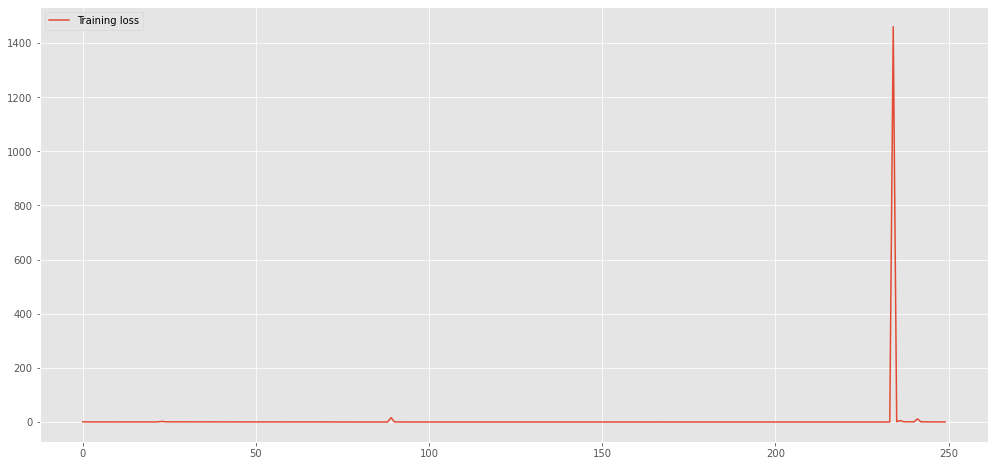

In [481]:
Loss_func = memory_bilstm.history["loss"] 
plt.plot(Loss_func, label= "Training loss")
plt.legend() # People may argue why I have schosen 1000 iterations, but the following diagram is self-descriptive!

In [482]:
bilstm.summary()

Model: "sequential_68"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 1024)              2105344   
_________________________________________________________________
dense_68 (Dense)             (None, 1)                 1025      
Total params: 2,106,369
Trainable params: 2,106,369
Non-trainable params: 0
_________________________________________________________________


In [483]:
score = bilstm.evaluate(X_train, Y_train, verbose = 0)
score #Customized loss and Logcosh 

[0.34711402654647827, 0.09668704122304916]

<function matplotlib.pyplot.show(close=None, block=None)>

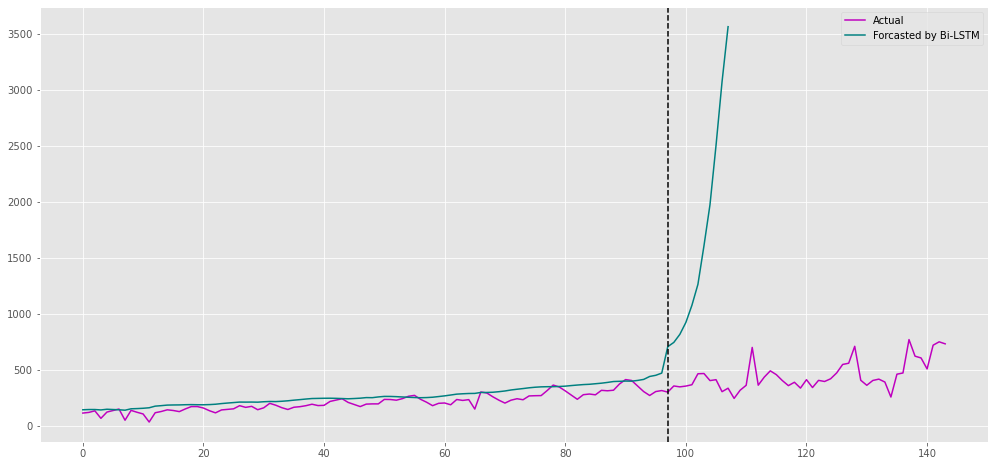

In [484]:
plt.plot(df, color="m")
plt.plot(pred, color="teal")
plt.legend(["Actual","Forcasted by Bi-LSTM"])
plt.axvline(len(X_train), c= "k", linestyle='dashed')
plt.show 
# The loss function that worked well for RNN, worked unsatisfactorily for LSTM, and completely failed for Bi-LSTM.

### Gated Recurrent Unit (GRU)

In [485]:
gru = Sequential()
gru.add(GRU(units=512, return_sequences=False, activation ="selu"))
gru.add(Dense(1, activation="bern_sigm"))
gru.compile(loss = custom_loss_function, optimizer='nadam', metrics="logcosh")
memory_gru = gru.fit(X_train, Y_train , epochs = 500, batch_size = 20, verbose = 1)

Epoch 1/500
5/5 [==============================] - 1s 38ms/step - loss: 0.8250 - logcosh: 0.1668
Epoch 2/500
5/5 [==============================] - 0s 42ms/step - loss: 0.7603 - logcosh: 0.1707
Epoch 3/500
5/5 [==============================] - 0s 37ms/step - loss: 0.5406 - logcosh: 0.1170
Epoch 4/500
5/5 [==============================] - 0s 38ms/step - loss: 0.5641 - logcosh: 0.1287
Epoch 5/500
5/5 [==============================] - 0s 42ms/step - loss: 0.4826 - logcosh: 0.1336
Epoch 6/500
5/5 [==============================] - 0s 30ms/step - loss: 0.5147 - logcosh: 0.1322
Epoch 7/500
5/5 [==============================] - 0s 32ms/step - loss: 0.4461 - logcosh: 0.1061
Epoch 8/500
5/5 [==============================] - 0s 30ms/step - loss: 0.4085 - logcosh: 0.1363
Epoch 9/500
5/5 [==============================] - 0s 31ms/step - loss: 0.4213 - logcosh: 0.1280
Epoch 10/500
5/5 [==============================] - 0s 31ms/step - loss: 0.3998 - logcosh: 0.1043
Epoch 11/500
5/5 [===========

5/5 [==============================] - 0s 31ms/step - loss: 0.0378 - logcosh: 0.0362
Epoch 85/500
5/5 [==============================] - 0s 30ms/step - loss: 0.0359 - logcosh: 0.0349
Epoch 86/500
5/5 [==============================] - 0s 30ms/step - loss: 0.0361 - logcosh: 0.0348
Epoch 87/500
5/5 [==============================] - 0s 29ms/step - loss: 0.0366 - logcosh: 0.0342
Epoch 88/500
5/5 [==============================] - 0s 31ms/step - loss: 0.0354 - logcosh: 0.0347
Epoch 89/500
5/5 [==============================] - 0s 31ms/step - loss: 0.0368 - logcosh: 0.0375
Epoch 90/500
5/5 [==============================] - 0s 30ms/step - loss: 0.0339 - logcosh: 0.0343
Epoch 91/500
5/5 [==============================] - 0s 31ms/step - loss: 0.0382 - logcosh: 0.0379
Epoch 92/500
5/5 [==============================] - 0s 30ms/step - loss: 0.0347 - logcosh: 0.0345
Epoch 93/500
5/5 [==============================] - 0s 32ms/step - loss: 0.0370 - logcosh: 0.0364
Epoch 94/500
5/5 [===============

5/5 [==============================] - 0s 31ms/step - loss: 0.1611 - logcosh: 0.0741
Epoch 168/500
5/5 [==============================] - 0s 29ms/step - loss: 0.1440 - logcosh: 0.0741
Epoch 169/500
5/5 [==============================] - 0s 32ms/step - loss: 0.1410 - logcosh: 0.0681
Epoch 170/500
5/5 [==============================] - 0s 33ms/step - loss: 0.0976 - logcosh: 0.0629
Epoch 171/500
5/5 [==============================] - 0s 30ms/step - loss: 0.0904 - logcosh: 0.0594
Epoch 172/500
5/5 [==============================] - 0s 31ms/step - loss: 0.3617 - logcosh: 0.0926
Epoch 173/500
5/5 [==============================] - 0s 30ms/step - loss: 0.1012 - logcosh: 0.0636
Epoch 174/500
5/5 [==============================] - 0s 31ms/step - loss: 0.1475 - logcosh: 0.0749
Epoch 175/500
5/5 [==============================] - 0s 30ms/step - loss: 0.1654 - logcosh: 0.0766
Epoch 176/500
5/5 [==============================] - 0s 30ms/step - loss: 0.1316 - logcosh: 0.0663
Epoch 177/500
5/5 [=====

5/5 [==============================] - 0s 32ms/step - loss: 0.0260 - logcosh: 0.0288
Epoch 250/500
5/5 [==============================] - 0s 32ms/step - loss: 0.0301 - logcosh: 0.0298
Epoch 251/500
5/5 [==============================] - 0s 41ms/step - loss: 0.0276 - logcosh: 0.0297
Epoch 252/500
5/5 [==============================] - 0s 30ms/step - loss: 0.0271 - logcosh: 0.0288
Epoch 253/500
5/5 [==============================] - 0s 30ms/step - loss: 0.0243 - logcosh: 0.0273
Epoch 254/500
5/5 [==============================] - 0s 31ms/step - loss: 0.0258 - logcosh: 0.0275
Epoch 255/500
5/5 [==============================] - 0s 30ms/step - loss: 0.0234 - logcosh: 0.0269
Epoch 256/500
5/5 [==============================] - 0s 30ms/step - loss: 0.0241 - logcosh: 0.0269
Epoch 257/500
5/5 [==============================] - 0s 33ms/step - loss: 0.0237 - logcosh: 0.0268
Epoch 258/500
5/5 [==============================] - 0s 31ms/step - loss: 0.0248 - logcosh: 0.0275
Epoch 259/500
5/5 [=====

5/5 [==============================] - 0s 30ms/step - loss: 0.0517 - logcosh: 0.0501
Epoch 332/500
5/5 [==============================] - 0s 33ms/step - loss: 0.0565 - logcosh: 0.0510
Epoch 333/500
5/5 [==============================] - 0s 37ms/step - loss: 0.0481 - logcosh: 0.0444
Epoch 334/500
5/5 [==============================] - 0s 30ms/step - loss: 0.0497 - logcosh: 0.0464
Epoch 335/500
5/5 [==============================] - 0s 30ms/step - loss: 0.0477 - logcosh: 0.0444
Epoch 336/500
5/5 [==============================] - 0s 31ms/step - loss: 0.0496 - logcosh: 0.0458
Epoch 337/500
5/5 [==============================] - 0s 35ms/step - loss: 0.0448 - logcosh: 0.0436
Epoch 338/500
5/5 [==============================] - 0s 30ms/step - loss: 0.0444 - logcosh: 0.0439
Epoch 339/500
5/5 [==============================] - 0s 32ms/step - loss: 0.0388 - logcosh: 0.0395
Epoch 340/500
5/5 [==============================] - 0s 31ms/step - loss: 0.0405 - logcosh: 0.0399
Epoch 341/500
5/5 [=====

5/5 [==============================] - 0s 32ms/step - loss: 0.0106 - logcosh: 0.0176
Epoch 414/500
5/5 [==============================] - 0s 30ms/step - loss: 0.0097 - logcosh: 0.0168
Epoch 415/500
5/5 [==============================] - 0s 30ms/step - loss: 0.0104 - logcosh: 0.0178
Epoch 416/500
5/5 [==============================] - 0s 30ms/step - loss: 0.0096 - logcosh: 0.0170
Epoch 417/500
5/5 [==============================] - 0s 30ms/step - loss: 0.0093 - logcosh: 0.0163
Epoch 418/500
5/5 [==============================] - 0s 29ms/step - loss: 0.0088 - logcosh: 0.0157
Epoch 419/500
5/5 [==============================] - 0s 30ms/step - loss: 0.0091 - logcosh: 0.0164
Epoch 420/500
5/5 [==============================] - 0s 29ms/step - loss: 0.0097 - logcosh: 0.0167
Epoch 421/500
5/5 [==============================] - 0s 30ms/step - loss: 0.0087 - logcosh: 0.0159
Epoch 422/500
5/5 [==============================] - 0s 31ms/step - loss: 0.0081 - logcosh: 0.0151
Epoch 423/500
5/5 [=====

5/5 [==============================] - 0s 33ms/step - loss: 0.0031 - logcosh: 0.0079
Epoch 496/500
5/5 [==============================] - 0s 30ms/step - loss: 0.0029 - logcosh: 0.0076
Epoch 497/500
5/5 [==============================] - 0s 32ms/step - loss: 0.0030 - logcosh: 0.0079
Epoch 498/500
5/5 [==============================] - 0s 30ms/step - loss: 0.0029 - logcosh: 0.0073
Epoch 499/500
5/5 [==============================] - 0s 32ms/step - loss: 0.0026 - logcosh: 0.0071
Epoch 500/500
5/5 [==============================] - 0s 32ms/step - loss: 0.0029 - logcosh: 0.0076


In [486]:
pred_train = SC.inverse_transform(gru.predict(X_train))
pred_test = SC.inverse_transform(gru.predict(X_test))

pred = pd.DataFrame(np.concatenate((pred_train,pred_test), axis = 0))

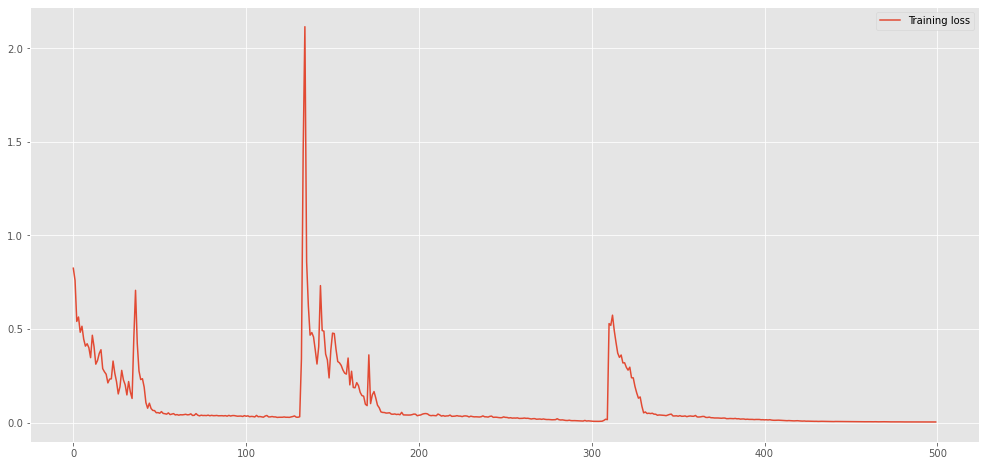

In [487]:
Loss_func = memory_gru.history["loss"] 
plt.plot(Loss_func, label= "Training loss")
plt.legend() 

In [488]:
gru.summary()

Model: "sequential_69"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 512)               791040    
_________________________________________________________________
dense_69 (Dense)             (None, 1)                 513       
Total params: 791,553
Trainable params: 791,553
Non-trainable params: 0
_________________________________________________________________


In [489]:
score = gru.evaluate(X_train, Y_train, verbose = 0)
score #Customized loss and Logcosh

[0.002691617701202631, 0.007051506545394659]

<function matplotlib.pyplot.show(close=None, block=None)>

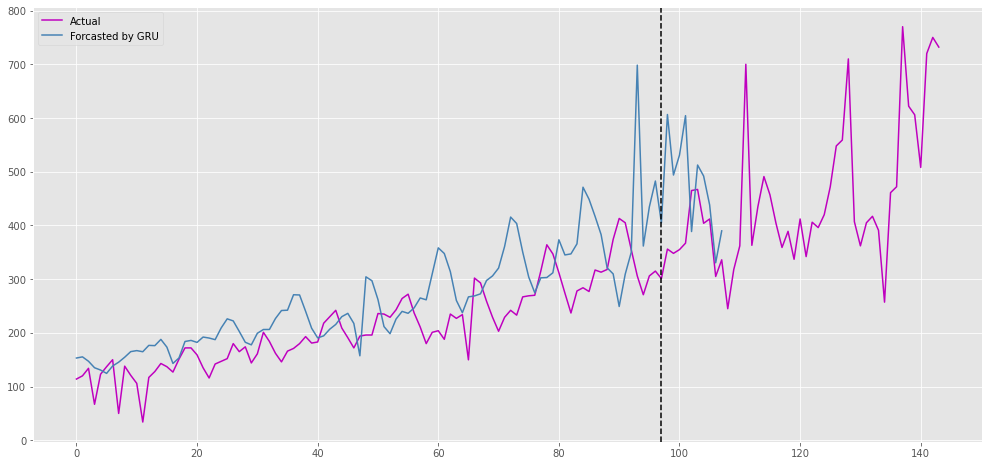

In [490]:
plt.plot(df, color="m")
plt.plot(pred, color="steelblue")
plt.legend(["Actual","Forcasted by GRU"])
plt.axvline(len(X_train), c= "k", linestyle='dashed')
plt.show
# The custom loss function here is not good but not bad either!

### <font color='steelblue'> The defined loss function works even better than RMSE for simple RNN, but poorly worked for LSTM and Bi-LSTM, and worked mediocrely for GRU.  </font>